### We corrected the temperature information to have only from t-1

In [1]:
import pandas as pd
import numpy as np
import math,os
from numpy.random import choice
import scikitplot as skplt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor

In [5]:
historicalColumns,neighborColumns = [],[]

for historical in range(5):
    historicalColumns += ['Tminus'+str(historical+1)]

for neighbor in range(26):
    neighborColumns += ['T'+str(neighbor+1)+'_t-1']

columns = ['timestep','x_voxel','y_voxel','z_voxel','layerNum','time_creation','x_laser','y_laser','z_laser','x_distance','y_distance','z_distance','euclidean_distance_laser'] + historicalColumns+ neighborColumns+['T_self']


### Utility Functions

In [6]:
def roundup(a, digits=4):
    n = 10**-digits
    return round(math.ceil(a / n) * n, digits)

def isEven(num):
    if num%2 ==0:
        return True
    return False

def modLog(num):
    try:
        return log(num)
    except:
        return 0

def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return np.load(fullPath)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
	'''
	scikit(sklearn) does not have support for mean absolute percentage error MAPE.
	This is because the denominator can theoretically be 0 and so the value would be undefined.
	So this is our implementation
	'''
# 	y_true = check_array(y_true)
# 	y_pred = check_array(y_pred)

	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def r2(y_true,y_pred):
    return roundup(r2_score(y_true,y_pred))

def mse(y_true,y_pred):
    return roundup(mean_squared_error(y_true,y_pred))

def mae(y_true,y_pred):
    return roundup(mean_absolute_error(y_true,y_pred))

def mape(y_true, y_pred):
    return roundup(mean_absolute_percentage_error(y_true,y_pred))

In [8]:
def combineDataFrames(prefix,columns=columns):
    List = []
    nums_start,nums_stop = [],[]
    for item in os.listdir('data_big'):
        if "data_big" in item and ".npy" in item:
            timeStep_start = int(item.split('data_big_')[1].split('_')[0])
            nums_start += [timeStep_start]
            
            timeStep_stop = int(item.split('_')[3].split('.npy')[0])
            nums_stop += [timeStep_stop]
            
    nums_start = sorted(nums_start)
    nums_stop = sorted(nums_stop)
    
    array = loadNumpy('data_big/'+prefix+'_'+str(nums_start[0])+'_'+str(nums_stop[0])+'.npy')
    for i in range(1,len(nums_start)):
        newFile = 'data_big/'+prefix+'_'+str(nums_start[i])+'_'+str(nums_stop[i])+'.npy'
        array = np.append(array,loadNumpy(newFile),axis=0)
    return pd.DataFrame(array,columns=columns)

In [9]:
df_big = combineDataFrames('data_big')

In [43]:
df = pd.read_csv('data/data_500_timesteps.csv')

In [45]:
df_train = df[df['timestep'] < 400.0]
df_test = df[df['timestep'] >= 400.0]

In [46]:
featureColumns = ['timestep','x_distance','y_distance','z_distance','time_creation','Tminus1']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

In [47]:
X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

In [48]:
X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [15]:
def display_top10Features(ensemble,featureColumns=featureColumns):
    List = ensemble.feature_importances_.argsort()[::-1][:10]
    String = ""
    for item in List: 
        String += str(featureColumns[item])
        String += '>'
    String += '...'
    return String

### Predicting timesteps next 100 (400-500) based on first 400 timesteps

In [16]:
linear = LinearRegression()
linear.fit(X_train,y_train)
predicted = linear.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9467118626196661, 3.6026120572233125)

In [29]:
ridge = Ridge()
ridge.fit(X_train,y_train)
predicted = ridge.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.946711925542481, 3.602592236221512)

In [18]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9899764965264769, 0.9564138986911235)

In [16]:
et = ExtraTreesRegressor(n_estimators=20, n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9912, 0.9237)

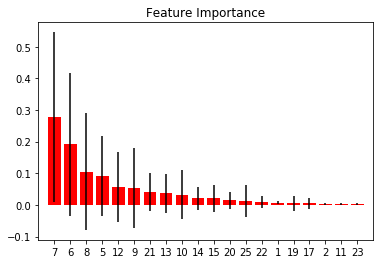

In [27]:
skplt.estimators.plot_feature_importances(et)

In [28]:
bag = BaggingRegressor(n_jobs=-1)
bag.fit(X_train,y_train)
predicted = bag.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9896074175516564, 0.891118002743491)

In [37]:
featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [38]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.991, 0.687)

In [50]:
et = ExtraTreesRegressor(n_estimators=20,n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9916, 0.6449)

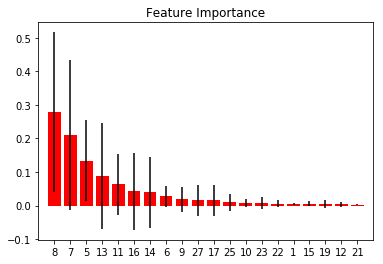

In [39]:
skplt.estimators.plot_feature_importances(et)

In [49]:
display_top10Features(et)

'T2_t-1>T1_t-1>Tminus1>T7_t-1>T5_t-1>T10_t-1>T8_t-1>Tminus2>T3_t-1>T21_t-1>...'

### <font color="red"> 10 layers -training on 950 and testing on rest timesteps </font>

In [10]:
df_train = df_big[df_big['timestep'] < 950.0]
df_test = df_big[df_big['timestep'] >= 950.0]

featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [62]:
linear = LinearRegression()
linear.fit(X_train,y_train)
predicted = linear.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9535, 1.8382)

In [11]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9945, 0.2429)

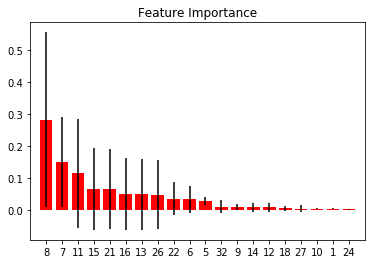

In [64]:
skplt.estimators.plot_feature_importances(et)

In [65]:
display_top10Features(et)

'T2_t-1>T1_t-1>T5_t-1>T9_t-1>T15_t-1>T10_t-1>T7_t-1>T20_t-1>T16_t-1>Tminus2>...'

In [73]:
df_train['euclidean_distance_laser'] = df_train.apply(lambda row: sqrt(row['x_distance']**2 + row['y_distance']**2 + row['z_distance']**2), axis=1)
df_test['euclidean_distance_laser'] = df_test.apply(lambda row: sqrt(row['x_distance']**2 + row['y_distance']**2 + row['z_distance']**2), axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
featureColumns = ['timestep','euclidean_distance_laser','x_distance','y_distance','z_distance','x_voxel','y_voxel','z_voxel',
                  'x_laser','y_laser','z_laser', 'layerNum','time_creation']

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [75]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.6667, 7.7084)

In [78]:
et = ExtraTreesRegressor(n_estimators=20,n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.6601, 7.547)

In [77]:
display_top10Features(et,featureColumns=featureColumns)

'y_distance>euclidean_distance_laser>z_distance>y_voxel>y_laser>timestep>z_laser>x_voxel>x_distance>layerNum>...'

### Model using only timestep and distance metrics 

In [67]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.4566, 11.9926)

### <font color="orange"> Train and test split almost equal - Training on 800 timesteps and testing on next 400 timesteps</font>

In [81]:
df_train = df_big[df_big['timestep'] < 800.0]
df_test = df_big[df_big['timestep'] >= 800.0]

featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [82]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9937, 0.3208)

#### <i>We realized that the % of the test set does not impact the model </i>

### <font color="magenta">Only select alternate time steps </font>

In [92]:
df_train = df_big[(df_big['timestep'] < 950.0) & (df_big['timestep']%2)]
df_test = df_big[(df_big['timestep'] >= 950.0) & (df_big['timestep']%2)]

In [97]:
featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [98]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9938, 0.2444)

### <font color="blue"> Select every 3rd timestep </font>

In [99]:
df_train = df_big[(df_big['timestep'] < 950.0) & (df_big['timestep']%3)]
df_test = df_big[(df_big['timestep'] >= 950.0) & (df_big['timestep']%3)]

featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [100]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9942, 0.2338)

### <font color="inkblue">  Considering distance from edge in the non-temperature based model </font>

In [103]:
df_big.head()

,timestep,x_voxel,y_voxel,z_voxel,layerNum,time_creation,x_laser,y_laser,z_laser,x_distance,...,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,T_self
0,1.0,0.5,1.5,0.5,1.0,2.0,0.0,0.75,0.5,0.5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,4.00
1,2.0,2.5,1.5,0.5,1.0,0.5,2.6,0.75,0.5,0.1,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3549.99
2,2.0,3.0,1.0,0.5,1.0,0.5,2.6,0.75,0.5,0.4,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3519.06
3,2.0,2.0,0.5,0.5,1.0,0.5,2.6,0.75,0.5,0.6,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3026.39
4,2.0,0.5,1.0,0.5,1.0,0.5,2.6,0.75,0.5,2.1,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1876.72


In [104]:
df_big['x_edge'] = df_big.apply(lambda row: (20-row['x_voxel']), axis=1)
df_big['y_edge'] = df_big.apply(lambda row: (20-row['y_voxel']), axis=1)


In [111]:
df_big['euclidean_distance_laser'] = df_big.apply(lambda row: sqrt(row['x_distance']**2 + row['y_distance']**2 + row['z_distance']**2), axis=1)

In [112]:
df_train = df_big[(df_big['timestep'] < 950.0) ]
df_test = df_big[(df_big['timestep'] >= 950.0) ]

featureColumns = ['timestep','euclidean_distance_laser','x_distance','y_distance','z_distance',
                  'x_voxel','y_voxel','z_voxel','x_laser','y_laser','z_laser', 'x_edge' ,'y_edge',
                  'layerNum','time_creation']

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [113]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.6926, 7.4871)

In [114]:
display_top10Features(et,featureColumns=featureColumns)

'y_distance>euclidean_distance_laser>y_laser>z_distance>timestep>y_voxel>y_edge>z_laser>z_voxel>x_distance>...'

### <font color="lightgreen"> Adding edge to the temperature information </font>

In [121]:
df_big.head()

,timestep,x_voxel,y_voxel,z_voxel,layerNum,time_creation,x_laser,y_laser,z_laser,x_distance,y_distance,z_distance,euclidean_distance_laser,Tminus1,Tminus2,Tminus3,Tminus4,Tminus5,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,T_self,x_edge,y_edge
0,1.0,0.5,1.5,0.5,1.0,2.0,0.0,0.75,0.5,0.5,0.75,0.0,0.901388,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,4.00,19.5,18.5
1,2.0,2.5,1.5,0.5,1.0,0.5,2.6,0.75,0.5,0.1,0.75,0.0,0.756637,300.0,-99.0,-99.0,-99.0,-99.0,3473.76,3520.21,3993.89,-99.00,-99.0,-99.0,3872.89,-99.00,3519.06,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3549.99,17.5,18.5
2,2.0,3.0,1.0,0.5,1.0,0.5,2.6,0.75,0.5,0.4,0.25,0.0,0.471699,300.0,-99.0,-99.0,-99.0,-99.0,3993.89,2973.47,3553.11,3520.21,-99.0,-99.0,3478.99,3549.99,1614.58,1614.62,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3519.06,17.0,19.0
3,2.0,2.0,0.5,0.5,1.0,0.5,2.6,0.75,0.5,0.6,0.25,0.0,0.650000,300.0,-99.0,-99.0,-99.0,-99.0,3324.64,3478.99,3876.13,3872.89,-99.0,-99.0,3303.29,2329.08,3996.03,3993.89,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3026.39,18.0,19.5
4,2.0,0.5,1.0,0.5,1.0,0.5,2.6,0.75,0.5,2.1,0.25,0.0,2.114829,300.0,-99.0,-99.0,-99.0,-99.0,1554.23,2706.98,1643.90,5.00,-99.0,-99.0,1959.09,1763.85,1754.33,2869.67,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1876.72,19.5,19.0


In [140]:
featureColumns = ['timestep','x_distance','y_distance','z_distance','x_edge','y_edge','layerNum','Tminus1','Tminus2','Tminus3']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [123]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.995, 0.2079)

In [124]:
display_top10Features(et,featureColumns=featureColumns)

'T5_t-1>T1_t-1>T2_t-1>T12_t-1>T10_t-1>T3_t-1>T15_t-1>Tminus3>Tminus1>T22_t-1>...'

#### <i> We find that the edge distance information does not appear in the top 10 features </i>

### <font color="purple"> Getting log for the temperature attributes </font>
#### log is undefined for non-positive values. modLog adjusts it and prevents from throwing an error

In [131]:
for i in range(5):
    suffix = 'Tminus'+str(i+1)
    df_big['log'+suffix] = df_big.apply(lambda row: modLog(row[suffix]), axis=1)

for i in range(26):
    suffix = 'T'+str(i+1)+'_t-1'
    df_big['log'+suffix] = df_big.apply(lambda row: modLog(row[suffix]), axis=1)

df_big['logT'] = df_big.apply(lambda row: modLog(row['T_self']), axis=1)

In [132]:
df_big.head()

,timestep,x_voxel,y_voxel,z_voxel,layerNum,time_creation,x_laser,y_laser,z_laser,x_distance,y_distance,z_distance,euclidean_distance_laser,Tminus1,Tminus2,Tminus3,Tminus4,Tminus5,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,T_self,x_edge,y_edge,logTminus1,logTminus2,logTminus3,logTminus4,logTminus5,logT1_t-1,logT2_t-1,logT3_t-1,logT4_t-1,logT5_t-1,logT6_t-1,logT7_t-1,logT8_t-1,logT9_t-1,logT10_t-1,logT11_t-1,logT12_t-1,logT13_t-1,logT14_t-1,logT15_t-1,logT16_t-1,logT17_t-1,logT18_t-1,logT19_t-1,logT20_t-1,logT21_t-1,logT22_t-1,logT23_t-1,logT24_t-1,logT25_t-1,logT26_t-1,logT
0,1.0,0.5,1.5,0.5,1.0,2.0,0.0,0.75,0.5,0.5,0.75,0.0,0.901388,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,4.00,19.5,18.5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.386294
1,2.0,2.5,1.5,0.5,1.0,0.5,2.6,0.75,0.5,0.1,0.75,0.0,0.756637,300.0,-99.0,-99.0,-99.0,-99.0,3473.76,3520.21,3993.89,-99.00,-99.0,-99.0,3872.89,-99.00,3519.06,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3549.99,17.5,18.5,5.703782,0.0,0.0,0.0,0.0,8.152993,8.166276,8.292521,0.000000,0.0,0.0,8.261756,0.000000,8.165949,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.174700
2,2.0,3.0,1.0,0.5,1.0,0.5,2.6,0.75,0.5,0.4,0.25,0.0,0.471699,300.0,-99.0,-99.0,-99.0,-99.0,3993.89,2973.47,3553.11,3520.21,-99.0,-99.0,3478.99,3549.99,1614.58,1614.62,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3519.06,17.0,19.0,5.703782,0.0,0.0,0.0,0.0,8.292521,7.997485,8.175579,8.166276,0.0,0.0,8.154497,8.174700,7.386830,7.386855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.165949
3,2.0,2.0,0.5,0.5,1.0,0.5,2.6,0.75,0.5,0.6,0.25,0.0,0.650000,300.0,-99.0,-99.0,-99.0,-99.0,3324.64,3478.99,3876.13,3872.89,-99.0,-99.0,3303.29,2329.08,3996.03,3993.89,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3026.39,18.0,19.5,5.703782,0.0,0.0,0.0,0.0,8.109117,8.154497,8.262593,8.261756,0.0,0.0,8.102674,7.753229,8.293057,8.292521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.015126
4,2.0,0.5,1.0,0.5,1.0,0.5,2.6,0.75,0.5,2.1,0.25,0.0,2.114829,300.0,-99.0,-99.0,-99.0,-99.0,1554.23,2706.98,1643.90,5.00,-99.0,-99.0,1959.09,1763.85,1754.33,2869.67,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1876.72,19.5,19.0,5.703782,0.0,0.0,0.0,0.0,7.348736,7.903589,7.404827,1.609438,0.0,0.0,7.580235,7.475254,7.469842,7.961952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.537281


In [133]:
logNeighborColumns = []
for neighbor in range(26):
    logNeighborColumns += ['logT'+str(neighbor+1)+'_t-1']


featureColumns = ['timestep','x_distance','y_distance','z_distance','x_edge','y_edge','layerNum']+['logTminus1','logTminus2','logTminus3']+logNeighborColumns


#### Saving the df with log 

In [136]:
df_log = df_big

### <font color="green"> Predicting based on log features </font>

In [134]:
df_train = df_big[(df_big['timestep'] < 950.0) ]
df_test = df_big[(df_big['timestep'] >= 950.0) ]

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [135]:
et = ExtraTreesRegressor(n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9944, 0.2177)

### SGD regression - regular temperature (not log)
It performs much worse than regular linear regression 

In [141]:
sgd = SGDRegressor()
sgd.fit(X_train,y_train)
predicted = sgd.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(-1.8800095347191276e+25, 65244174206837.11)

In [142]:
linear = LinearRegression()
linear.fit(X_train,y_train)
predicted = linear.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9535, 1.8475)

In [145]:
elastic = ElasticNet()
elastic.fit(X_train,y_train)
predicted = elastic.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9536, 1.8262)

In [151]:
elastic = ElasticNet(l1_ratio =0.2)
elastic.fit(X_train,y_train)
predicted = elastic.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9536, 1.8275)

In [148]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train,y_train)
predicted = rf.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9941, 0.2079)

In [153]:
rf = RandomForestRegressor(n_jobs=-1,n_estimators=3)
rf.fit(X_train,y_train)
predicted = rf.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9918, 0.2494)

In [150]:
dt = DecisionTreeRegressor(random_state=300)
dt.fit(X_train,y_train)
predicted = dt.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9867, 0.2971)

### To do Friday 
* Run experiments on the smaller sample 
* See if the log of attributes impact the results 
* See the R2 across missing values 

### <font color="red"> Exploratory Analysis for Different Types of Voxels </font>

In [49]:
et = ExtraTreesRegressor(n_estimators=20, n_jobs=-1)
et.fit(X_train,y_train)
predicted = et.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9914, 0.8673)

#### R2 is 0.9912 for extra Trees

In [17]:
X_train.head()

,timestep,x_distance,y_distance,z_distance,time_creation,Tminus1,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1
690604,314.0,10.768543,1.75,0.5,1.0,1543.870,1341.520,1484.760,1498.600,1368.740,1409.590,1426.00,1467.440,1461.420,1485.200,1393.550,1432.330,1321.170,1511.080,1510.690,1297.640,1431.360,1440.280,1502.59,1410.910,1424.800,1483.27,1342.030,1477.530,1394.610,1496.410,1455.290
514301,270.0,14.331458,7.25,0.5,1.0,754.711,759.614,758.988,748.478,765.633,765.761,-99.00,750.655,771.674,738.596,741.559,744.741,748.402,-99.000,-99.000,759.720,759.107,-99.000,-99.00,753.564,771.811,738.41,741.592,-99.000,-99.000,-99.000,-99.000
11216,37.0,5.900000,0.75,0.0,0.5,1046.450,1009.290,975.481,1001.650,-99.000,-99.000,-99.00,976.853,-99.000,993.239,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.00,-99.000,-99.000,-99.00,-99.000,-99.000,-99.000,-99.000,-99.000
754700,329.0,0.231457,4.75,0.5,1.0,600.804,625.242,617.432,606.607,619.809,617.407,-99.00,608.922,611.694,597.678,604.373,599.761,603.989,-99.000,-99.000,624.134,593.696,-99.000,-99.00,606.449,610.298,601.51,614.770,-99.000,-99.000,-99.000,-99.000
662509,308.0,0.131457,9.25,0.5,1.0,1015.170,984.093,1008.580,984.060,967.038,940.569,1010.99,967.176,959.588,983.097,965.986,999.322,948.935,987.751,971.924,972.060,940.357,987.775,1011.13,999.212,939.890,971.03,947.869,972.052,965.118,986.792,970.876


In [19]:
len(X_test)

610671

Steps: 
* Create a small subset of data 
* Check how much time it takes to create the check for a small dataset 
* Implement on big dataset 
* Make a function for that 
* Check for training set - use it as a training parameter 
* Check for other types 

In [37]:
X_test['voxelLat'] = 'present'
X_test['voxelLat'][X_test['T1_t-1']==-99] = 'absent'
X_test['voxelLat'][X_test['T2_t-1']==-99] = 'absent'
X_test['voxelLat'].value_counts()

present    580628
absent      30043
Name: voxelLat, dtype: int64

In [38]:
X_test['voxelLong'] = 'present'
X_test['voxelLong'][X_test['T3_t-1']==-99] = 'absent'
X_test['voxelLong'][X_test['T4_t-1']==-99] = 'absent'
X_test['voxelLong'].value_counts()

present    577848
absent      32823
Name: voxelLong, dtype: int64

In [39]:
X_test['voxelVert'] = 'present'
X_test['voxelVert'][X_test['T5_t-1']==-99] = 'absent'
X_test['voxelVert'][X_test['T6_t-1']==-99] = 'absent'
X_test['voxelVert'].value_counts()

absent     336200
present    274471
Name: voxelVert, dtype: int64

#### Assigning voxel Types


In [114]:
X_test['voxelType'] = 'someMissing'
X_test['voxelType'][X_test['voxelVert']=='absent'] = 'vertMissing'
X_test['voxelType'][X_test['voxelLong']=='absent'] = 'longMissing'
X_test['voxelType'][X_test['voxelLat']=='absent'] = 'latMissing'

In [115]:
X_test.loc[(X_test['T1_t-1']!= -99) & (X_test['T2_t-1'] != -99) & (X_test['T3_t-1']!= -99) & (X_test['T4_t-1'] != -99)
              &(X_test['T5_t-1']!= -99) & (X_test['T6_t-1'] != -99) & (X_test['T7_t-1']!= -99) & (X_test['T8_t-1'] != -99)
              &(X_test['T9_t-1']!= -99) & (X_test['T10_t-1'] != -99) & (X_test['T11_t-1']!= -99) & (X_test['T12_t-1'] != -99)
              &(X_test['T13_t-1']!= -99) & (X_test['T14_t-1'] != -99) & (X_test['T15_t-1']!= -99) & (X_test['T16_t-1'] != -99)
              &(X_test['T17_t-1']!= -99) & (X_test['T18_t-1'] != -99) & (X_test['T19_t-1']!= -99) & (X_test['T20_t-1'] != -99)
              &(X_test['T21_t-1']!= -99) & (X_test['T22_t-1'] != -99) & (X_test['T23_t-1']!= -99) & (X_test['T24_t-1'] != -99)
              & (X_test['T25_t-1']!= -99) & (X_test['T26_t-1'] != -99),['voxelType']] = 'interior'

In [116]:
X_test['voxelType'].value_counts()

vertMissing    300469
interior       245209
longMissing     31080
latMissing      30043
someMissing      3870
Name: voxelType, dtype: int64

In [127]:
def percent_counts(series):
    length = float(len(series))
    count_dict = dict(series.value_counts())
    percent_dict = {}
    for key in count_dict:
        percent_dict[key] = count_dict[key]/length
    return percent_dict


In [128]:
percent_counts(X_test['voxelType'])

{'interior': 0.40154027291291056,
 'latMissing': 0.04919670329850279,
 'longMissing': 0.05089483535324258,
 'someMissing': 0.00633729127467982,
 'vertMissing': 0.4920308971606642}

#### Extract elements based on type

In [117]:
test = np.array(y_test)
test_someMissing = np.array([test[index] for index in list(np.where(X_test['voxelType']=='someMissing')[0])])

predicted_someMissing = np.array([predicted[index] for index in list(np.where(X_test['voxelType']=='someMissing')[0])])

In [105]:
test_latMissing = np.array([test[index] for index in list(np.where(X_test['voxelType']=='latMissing')[0])])

predicted_latMissing = np.array([predicted[index] for index in list(np.where(X_test['voxelType']=='latMissing')[0])])

In [106]:
test_longMissing = np.array([test[index] for index in list(np.where(X_test['voxelType']=='longMissing')[0])])

predicted_longMissing = np.array([predicted[index] for index in list(np.where(X_test['voxelType']=='longMissing')[0])])

In [107]:
test_vertMissing = np.array([test[index] for index in list(np.where(X_test['voxelType']=='vertMissing')[0])])

predicted_vertMissing = np.array([predicted[index] for index in list(np.where(X_test['voxelType']=='vertMissing')[0])])

In [108]:
test_interior = np.array([test[index] for index in list(np.where(X_test['voxelType']=='interior')[0])])

predicted_interior = np.array([predicted[index] for index in list(np.where(X_test['voxelType']=='interior')[0])])

In [109]:
r2(test_interior,predicted_interior) ,mape(test_interior,predicted_interior)

(0.9938, 0.742)

In [110]:
r2(test_latMissing,predicted_latMissing) ,mape(test_latMissing,predicted_latMissing)

(0.9709, 1.6599)

In [111]:
r2(test_longMissing,predicted_longMissing) ,mape(test_longMissing,predicted_longMissing)

(0.9977, 0.8443)

In [112]:
r2(test_vertMissing,predicted_vertMissing) ,mape(test_vertMissing,predicted_vertMissing)

(0.9905, 1.0018)

In [118]:
r2(test_someMissing,predicted_someMissing) ,mape(test_someMissing,predicted_someMissing)

(0.9876, 1.2921)

#### Create efficient Functions for voxelType

In [129]:
def assignVoxelTypes(df):
    df['voxelLat'] = 'present'
    df['voxelLat'][df['T1_t-1']==-99] = 'absent'
    df['voxelLat'][df['T2_t-1']==-99] = 'absent'
    
    df['voxelLong'] = 'present'
    df['voxelLong'][df['T3_t-1']==-99] = 'absent'
    df['voxelLong'][df['T4_t-1']==-99] = 'absent'
    
    df['voxelVert'] = 'present'
    df['voxelVert'][df['T5_t-1']==-99] = 'absent'
    df['voxelVert'][df['T6_t-1']==-99] = 'absent'
    
    df['voxelType'] = 'someMissing'
    df['voxelType'][df['voxelVert']=='absent'] = 'vertMissing'
    df['voxelType'][df['voxelLong']=='absent'] = 'longMissing'
    df['voxelType'][df['voxelLat']=='absent'] = 'latMissing'
    
    df.loc[(df['T1_t-1']!= -99) & (df['T2_t-1'] != -99) & (df['T3_t-1']!= -99) & (df['T4_t-1'] != -99)
              &(df['T5_t-1']!= -99) & (df['T6_t-1'] != -99) & (df['T7_t-1']!= -99) & (df['T8_t-1'] != -99)
              &(df['T9_t-1']!= -99) & (df['T10_t-1'] != -99) & (df['T11_t-1']!= -99) & (df['T12_t-1'] != -99)
              &(df['T13_t-1']!= -99) & (df['T14_t-1'] != -99) & (df['T15_t-1']!= -99) & (df['T16_t-1'] != -99)
              &(df['T17_t-1']!= -99) & (df['T18_t-1'] != -99) & (df['T19_t-1']!= -99) & (df['T20_t-1'] != -99)
              &(df['T21_t-1']!= -99) & (df['T22_t-1'] != -99) & (df['T23_t-1']!= -99) & (df['T24_t-1'] != -99)
              & (df['T25_t-1']!= -99) & (df['T26_t-1'] != -99),['voxelType']] = 'interior'
    

In [132]:
def assignRows_voxelType(List,df,voxelType):
    labels_voxelType = np.array([List[index] for index in list(np.where(df['voxelType']==voxelType)[0])])
    return labels_voxelType

In [167]:
def predictVoxelType(df,TIMESTEP,featureColumns=featureColumns):

    
    ###Train and Test Split 
    df_train = df[(df['timestep'] < TIMESTEP) ]
    df_test = df[(df['timestep'] >= TIMESTEP) ]


    X_train = df_train.loc[:,featureColumns ]
    y_train = df_train['T_self']

    X_test = df_test.loc[:,featureColumns ]
    y_test = df_test['T_self']
    

    X_train,y_train = shuffle(X_train,y_train,random_state=300)
    X_test,y_test = shuffle(X_test,y_test,random_state=300)
    
    ###Algorithm
    et = ExtraTreesRegressor(n_jobs=-1)
    et.fit(X_train,y_train)
    predicted = et.predict(X_test)
    
    ###assign types of voxels
    test = np.array(y_test)
    
    ###Assign the voxel Types 
    assignVoxelTypes(df_test)
    
    test_someMissing = assignRows_voxelType(test,df_test,'someMissing')
    predicted_someMissing = assignRows_voxelType(predicted,df_test,'someMissing')
    
    test_latMissing = assignRows_voxelType(test,df_test,'latMissing')
    predicted_latMissing = assignRows_voxelType(predicted,df_test,'latMissing')
    
    test_longMissing = assignRows_voxelType(test,df_test,'longMissing')
    predicted_longMissing = assignRows_voxelType(predicted,df_test,'longMissing')
    
    test_vertMissing = assignRows_voxelType(test,df_test,'vertMissing')
    predicted_vertMissing = assignRows_voxelType(predicted,df_test,'vertMissing')
    
    test_interior = assignRows_voxelType(test,df_test,'interior')
    predicted_interior = assignRows_voxelType(predicted,df_test,'interior')
    
    ###Displaying the results
    print 'Interior Voxels'
    print r2(test_interior,predicted_interior) ,mape(test_interior,predicted_interior)
    
    print 'Voxels with missing lateral neighbors'
    print r2(test_latMissing,predicted_latMissing) ,mape(test_latMissing,predicted_latMissing)
    
    print 'Voxels with missing longitudinal neighbors'
    print r2(test_longMissing,predicted_longMissing) ,mape(test_longMissing,predicted_longMissing)
    
    print 'Voxels with missing vertical neighbors'
    print r2(test_vertMissing,predicted_vertMissing) ,mape(test_vertMissing,predicted_vertMissing)
    
    print 'Voxels with missing some other neighbors'
    print r2(test_someMissing,predicted_someMissing) ,mape(test_someMissing,predicted_someMissing)

#### Predicting based on Voxel Type

In [168]:
df = pd.read_csv('data/data_500_timesteps.csv')
featureColumns = ['timestep','x_distance','y_distance','z_distance','time_creation','Tminus1']+neighborColumns
predictVoxelType(df,400,featureColumns)

Interior Voxels
0.9902 0.9155
Voxels with missing lateral neighbors
0.992 0.8983
Voxels with missing longitudinal neighbors
0.9885 0.9234
Voxels with missing vertical neighbors
0.9899 0.9177
Voxels with missing some other neighbors
0.9883 0.926


In [169]:
df_big = combineDataFrames('data_big')
featureColumns = ['timestep','x_distance','y_distance','z_distance','time_creation','Tminus1']+neighborColumns
predictVoxelType(df_big,950,featureColumns)

Interior Voxels
0.9947 0.3055
Voxels with missing lateral neighbors
0.9945 0.3054
Voxels with missing longitudinal neighbors
0.995 0.3083
Voxels with missing vertical neighbors
0.9945 0.3081
Voxels with missing some other neighbors
0.9923 0.2942


#### Apply the function on X_train

In [130]:
assignVoxelTypes(X_train)

### <font color="orange"> Exploratory Analysis for Spatially Distinct Points  </font>

In [209]:
X_test.sort_values('timestep',axis=0).tail()

,timestep,x_distance,y_distance,z_distance,time_creation,Tminus1,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,x_y_z
1710114,499.0,10.0,0.625732,1.125019,1.0,1423.050,1333.890,1335.760,1370.260,1335.320,1378.310,1424.120,1403.500,1368.560,1408.320,1370.990,1347.740,1316.830,1383.970,1346.270,1315.480,1317.21,1421.150,1346.760,1375.480,1346.110,1380.140,1348.400,1382.230,1344.800,1426.080,1384.740,10.0_0.625732261421_1.12501877593
1711909,499.0,9.0,9.374268,0.625019,1.5,925.154,919.963,922.913,950.905,979.005,934.671,921.484,949.729,976.986,951.324,980.233,920.911,977.841,950.586,978.708,932.788,922.03,919.655,922.600,919.076,975.819,950.343,979.070,949.413,976.693,951.004,979.933,9.0_9.37426773858_0.625018775934
1709839,499.0,13.0,9.874268,1.125019,1.0,935.846,937.045,926.836,923.274,909.799,930.005,933.298,927.230,913.654,918.634,905.281,921.132,907.742,924.219,910.706,911.605,903.21,938.051,927.872,934.784,925.097,924.539,916.479,928.166,914.551,919.592,906.200,13.0_9.87426773858_1.12501877593
1712417,499.0,0.0,11.374268,1.625019,0.5,791.748,-99.000,776.454,779.615,800.087,-99.000,798.947,-99.000,-99.000,766.525,786.526,-99.000,-99.000,776.369,796.549,-99.000,-99.00,-99.000,788.663,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,786.323,806.992,0.0_11.3742677386_1.62501877593
1710575,499.0,20.0,7.374268,1.625019,0.5,879.195,861.027,-99.000,850.254,887.216,-99.000,888.403,854.153,871.894,-99.000,-99.000,-99.000,-99.000,851.325,885.333,-99.000,-99.00,873.853,-99.000,-99.000,-99.000,-99.000,-99.000,865.392,896.992,-99.000,-99.000,20.0_7.37426773858_1.62501877593


In [216]:
X_train_small = X_train.sort_values('timestep',axis=0).head(1000)
X_test_small = X_test.sort_values('timestep',axis=0).head(1000)

In [215]:
X_train_small.head()

,timestep,x_distance,y_distance,z_distance,time_creation,Tminus1,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,x_y_z
0,1.0,0.5,0.75,0.0,2.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.5_0.75_0.0
21,2.0,0.9,0.25,0.0,0.5,300.0,3553.11,-99.00,-99.00,2973.47,-99.0,-99.0,2975.86,3519.06,-99.00,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.9000000026_0.25_0.0
2,2.0,0.4,0.25,0.0,0.5,300.0,3993.89,2973.47,3553.11,3520.21,-99.0,-99.0,3478.99,3549.99,1614.58,1614.62,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.4000000026_0.25_0.0
26,2.0,1.1,0.75,0.0,0.5,300.0,2869.67,3473.76,2329.08,-99.00,-99.0,-99.0,2706.98,-99.00,3872.89,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0999999974_0.75_0.0
30,2.0,2.1,0.75,0.0,0.5,300.0,1845.84,2389.49,-99.00,1643.90,-99.0,-99.0,-99.00,1959.09,-99.00,1754.33,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2.0999999974_0.75_0.0


In [123]:
X_train = X_train.round({'x_distance':2, 'y_distance':2, 'z_distance':2})

In [124]:
X_train["x_y_z"] = X_train["x_distance"].map(str) + "_" + X_train["y_distance"].map(str)+ "_" + X_train["z_distance"].map(str)

In [125]:
X_test = X_test.round({'x_distance':2, 'y_distance':2, 'z_distance':2})

In [126]:
X_test["x_y_z"] = X_test["x_distance"].map(str) + "_" + X_test["y_distance"].map(str)+ "_" + X_test["z_distance"].map(str)

In [20]:
X_train.head()

,timestep,x_distance,y_distance,z_distance,time_creation,Tminus1,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,x_y_z
690604,314.0,10.77,1.75,0.5,1.0,1543.870,1341.520,1484.760,1498.600,1368.740,1409.590,1426.00,1467.440,1461.420,1485.200,1393.550,1432.330,1321.170,1511.080,1510.690,1297.640,1431.360,1440.280,1502.59,1410.910,1424.800,1483.27,1342.030,1477.530,1394.610,1496.410,1455.290,10.77_1.75_0.5
514301,270.0,14.33,7.25,0.5,1.0,754.711,759.614,758.988,748.478,765.633,765.761,-99.00,750.655,771.674,738.596,741.559,744.741,748.402,-99.000,-99.000,759.720,759.107,-99.000,-99.00,753.564,771.811,738.41,741.592,-99.000,-99.000,-99.000,-99.000,14.33_7.25_0.5
11216,37.0,5.90,0.75,0.0,0.5,1046.450,1009.290,975.481,1001.650,-99.000,-99.000,-99.00,976.853,-99.000,993.239,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.00,-99.000,-99.000,-99.00,-99.000,-99.000,-99.000,-99.000,-99.000,5.9_0.75_0.0
754700,329.0,0.23,4.75,0.5,1.0,600.804,625.242,617.432,606.607,619.809,617.407,-99.00,608.922,611.694,597.678,604.373,599.761,603.989,-99.000,-99.000,624.134,593.696,-99.000,-99.00,606.449,610.298,601.51,614.770,-99.000,-99.000,-99.000,-99.000,0.23_4.75_0.5
662509,308.0,0.13,9.25,0.5,1.0,1015.170,984.093,1008.580,984.060,967.038,940.569,1010.99,967.176,959.588,983.097,965.986,999.322,948.935,987.751,971.924,972.060,940.357,987.775,1011.13,999.212,939.890,971.03,947.869,972.052,965.118,986.792,970.876,0.13_9.25_0.5


In [21]:
len(X_train), len(X_test)

(1105639, 610671)

In [22]:
X_spatiallyNonUniq = X_test[X_test['x_y_z'].isin(list(set(X_train['x_y_z'])))]

In [23]:
X_spatiallyUniq = X_test[~X_test['x_y_z'].isin(list(set(X_train['x_y_z'])))]

In [24]:
len(X_spatiallyUniq), len(X_spatiallyNonUniq)

(112496, 498175)

To Do : 
* We have the data points for points that are unique and those that are not unique. 
* We need to find the R2 values for those points 
* Further, we can differentiate these points based on the type of voxels 

In [25]:
test = np.array(y_test)

In [26]:
X_spatiallyUniq.head()

,timestep,x_distance,y_distance,z_distance,time_creation,Tminus1,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,x_y_z
1213525,419.0,6.05,5.75,0.0,2.0,1149.280,1104.350,1112.20,1094.47,1076.63,1119.930,-99.0,1107.83,1089.51,1084.93,1072.620,1086.62,1073.30,-99.0,-99.0,1096.87,1067.71,-99.0,-99.0,1100.84,1081.410,1076.27,1057.740,-99.0,-99.0,-99.0,-99.0,6.05_5.75_0.0
1570706,478.0,9.35,2.75,0.0,2.0,1583.610,1711.350,1702.64,1707.04,1659.95,1698.280,-99.0,1657.71,1561.10,1659.81,1559.740,1641.10,1548.91,-99.0,-99.0,1549.25,1547.34,-99.0,-99.0,1702.98,1640.860,1694.43,1641.240,-99.0,-99.0,-99.0,-99.0,9.35_2.75_0.0
1509993,468.0,0.35,8.25,0.0,2.0,1137.400,1157.060,1153.68,1183.79,1241.22,1155.400,-99.0,1131.60,1241.89,1128.03,1269.370,1129.94,1270.55,-99.0,-99.0,1156.61,1127.67,-99.0,-99.0,1131.26,1240.920,1182.15,1268.080,-99.0,-99.0,-99.0,-99.0,0.35_8.25_0.0
1520165,470.0,6.55,11.75,0.0,2.0,995.834,990.403,1029.53,1029.08,1009.71,990.705,-99.0,1027.74,1009.28,1009.28,990.392,1028.99,1009.63,-99.0,-99.0,1027.66,1029.45,-99.0,-99.0,1009.20,990.288,1009.19,990.276,-99.0,-99.0,-99.0,-99.0,6.55_11.75_0.0
1228187,422.0,9.50,3.00,0.0,2.0,1436.910,1508.420,1503.21,1605.11,1759.43,1416.930,-99.0,1427.96,1710.42,1421.31,1729.040,1590.60,1709.68,-99.0,-99.0,1496.76,1413.17,-99.0,-99.0,1420.06,1702.110,1589.20,1763.730,-99.0,-99.0,-99.0,-99.0,9.5_3.0_0.0


In [40]:
uniqIndices = np.array(X_spatiallyUniq.index)


In [100]:
uniqIndices[:5]

array([1213525, 1570706, 1509993, 1520165, 1228187])

In [101]:
for key in y_test.keys()[:5]:
    print key

1461147
1658710
1492606
1635688
1213525


In [ ]:
testDict[1461147]

In [99]:
len(y_test.keys()), len(keys)

(610671, 610671)

In [107]:
test[0], y_test.iloc[0]

(1178.09, 1178.09)

In [109]:
testDict, predictDict = {},{}
keys = y_test.keys()
for i in range(len(keys)):
    testDict[keys[i]] = test[i]
    predictDict[keys[i]] = predicted[i]

In [110]:
test_uniq, predicted_uniq = [],[]
test_nonuniq, predicted_nonuniq = [],[]
for index in y_test.keys():
    if index in uniqIndices:
        test_uniq += [testDict[index]]
        predicted_uniq +=  [predictDict[index]]
    else:
        test_nonuniq +=  [ testDict[index]]
        predicted_nonuniq +=  [ predictDict[index]]


In [111]:
len(predicted_nonuniq), len(test_uniq), len(predicted_uniq)

(498175, 112496, 112496)

In [112]:
r2(test_nonuniq, predicted_nonuniq)

0.9918

In [113]:
r2(test_uniq, predicted_uniq)

0.986

### Big Simulation 

In [12]:
X_spatiallyNonUniq = X_test[X_test['x_y_z'].isin(list(set(X_train['x_y_z'])))]

KeyError: 'x_y_z'

In [ ]:
X_spatiallyUniq = X_test[~X_test['x_y_z'].isin(list(set(X_train['x_y_z'])))]

In [ ]:
len(X_test), len(X_train)

In [ ]:
len(X_spatiallyUniq), len(X_spatiallyNonUniq)

In [ ]:
test = np.array(y_test)

In [142]:
len(test), len(y_test), len(X_spatiallyUniq), len(X_spatiallyNonUniq)

(2956764, 2956764, 1683503, 1273261)

In [ ]:
predicted[1], test[1], predicted[-1], test[-1]

In [140]:
uniqIndices = np.array(X_spatiallyUniq.index)
testDict, predictDict = {},{}
keys = y_test.keys()
for i in range(len(keys)):
    testDict[keys[i]] = y_test.iloc[i]
    predictDict[keys[i]] = predicted[i]
    
test_uniq, predicted_uniq = [],[]
test_nonuniq, predicted_nonuniq = [],[]
for index in keys:
    if index in uniqIndices:
        test_uniq += [testDict[index]]
        predicted_uniq +=  [predictDict[index]]
    else:
        test_nonuniq +=  [ testDict[index]]
        predicted_nonuniq +=  [ predictDict[index]]

IndexError: index 610671 is out of bounds for axis 0 with size 610671

In [ ]:
r2(test_nonuniq, predicted_nonuniq)

In [ ]:
r2(test_uniq, predicted_uniq)